<a href="https://colab.research.google.com/github/Morganblabla/Estadistica/blob/main/Proyeto_Seriesdetiempo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# J.P Morgan

Importar dataframe del 14 de abril de 2023 al 14 de abril de 2025

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

df = yf.download(
    tickers='JPM',
    start='2023-04-01',        # Fecha de inicio
    end='2025-04-01',          # Fecha de fin
    interval='1d',             # Intervalo de tiempo (1 día)
    group_by=None,
    auto_adjust=False,
    actions=False,
    )

# Link para inspeccionar tickers: https://www.nasdaq.com/market-activity/stocks/screener
df = df.reset_index()
df.columns = ['_'.join(col).strip() if col[1] != '' else col[0] for col in df.columns.values]
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.date
df.set_index('Date', inplace=True)

df

[*********************100%***********************]  1 of 1 completed


,JPM_Open,JPM_High,JPM_Low,JPM_Close,JPM_Adj Close,JPM_Volume
Date,,,,,,
2023-04-03,129.910004,131.440002,129.410004,130.160004,122.960167,11775400
2023-04-04,130.500000,130.589996,127.410004,128.419998,121.316422,11579900
2023-04-05,126.800003,128.149994,126.459999,127.610001,121.497330,9614700
2023-04-06,127.000000,128.080002,126.860001,127.470001,121.364029,8760200
2023-04-10,126.540001,128.229996,126.220001,127.889999,121.763893,9477300
...,...,...,...,...,...,...
2025-03-25,249.309998,251.820007,247.619995,251.130005,249.592636,9287700
2025-03-26,252.600006,254.669998,249.779999,251.029999,249.493240,12779300
2025-03-27,249.529999,250.639999,247.179993,248.119995,246.601044,8022500


Calculo de medias móviles

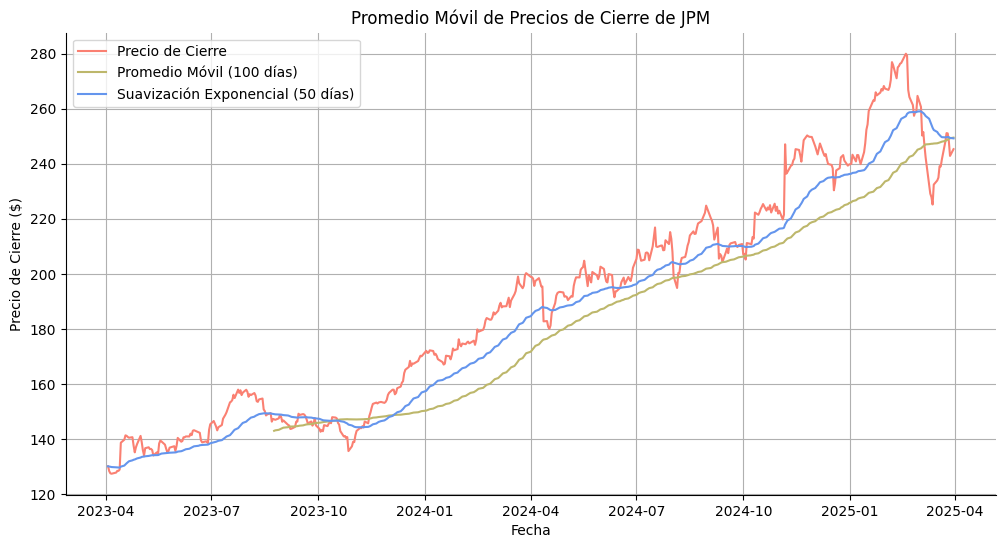

In [3]:
# Promedio Móvil Simple
ventana_sma = 100
df['SMA'] = df['JPM_Close'].rolling(window=ventana_sma).mean()

# Promedio Móvil Exponencial
ventana_ses = 50
df['SES'] = df['JPM_Close'].ewm(span=ventana_ses, adjust=False).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['JPM_Close'], label='Precio de Cierre', color='salmon')
plt.plot(df['SMA'], label=f'Promedio Móvil ({ventana_sma} días)', color='darkkhaki')
plt.plot(df['SES'], label=f'Suavización Exponencial ({ventana_ses} días)', color='cornflowerblue')
plt.title('Promedio Móvil de Precios de Cierre de JPM')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.grid()
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

Prueba Dickey-Fuller Aumentada

In [4]:
#Hipótesis nula (H₀): La serie tiene una raíz unitaria (no es estacionaria).
#Hipótesis alternativa (H₁): La serie es estacionaria.

from statsmodels.tsa.stattools import adfuller

nivel_de_significancia = 0.05

adf_test = adfuller(df['JPM_Close'].dropna())

print('Estadístico ADF:', adf_test[0])
print('p-value:', adf_test[1])

if adf_test[1] <= nivel_de_significancia:
    print("La tendencia es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La tendencia no es estacionaria (aceptamos la hipótesis nula).")

Estadístico ADF: -0.834830944739074
p-value: 0.8086760705321364
La tendencia no es estacionaria (aceptamos la hipótesis nula).


Regresión polinomial

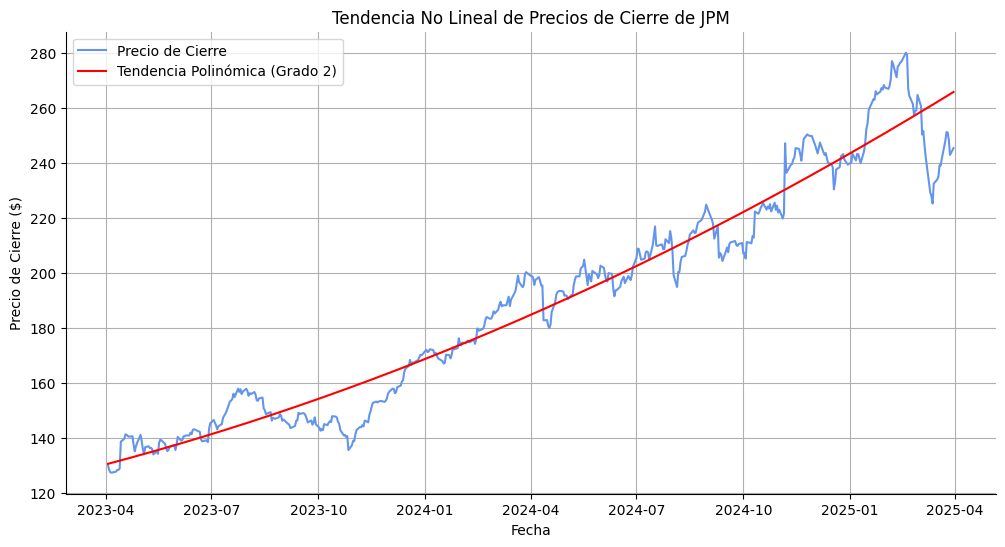

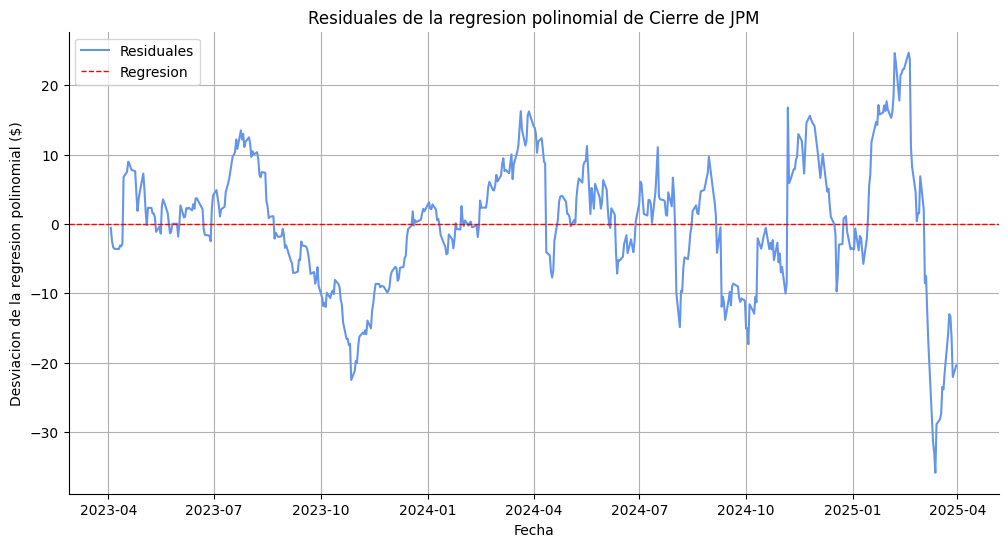

In [5]:
from numpy.polynomial.polynomial import Polynomial

df['Date'] = pd.to_datetime(df.index).map(pd.Timestamp.timestamp)

X = df['Date']
y = df['JPM_Close']

grado = 2
modelo = Polynomial.fit(X, y, deg = grado)
df['Poly_Trend'] = modelo(X)
df['Poly_Resid'] = y - df['Poly_Trend']

plt.figure(
    figsize=(12, 6)
    )

plt.plot(
    y,
    label='Precio de Cierre',
    color='cornflowerblue'
    )

plt.plot(df['Poly_Trend'], label=f'Tendencia Polinómica (Grado {grado})', color='red')
plt.title('Tendencia No Lineal de Precios de Cierre de JPM')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(df['Poly_Resid'], label='Residuales', color='cornflowerblue')
plt.axhline(0, color='red', label='Regresion',linestyle='--', linewidth=1)
plt.title('Residuales de la regresion polinomial de Cierre de JPM')
plt.xlabel('Fecha')
plt.ylabel('Desviacion de la regresion polinomial ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

Para Pros: Series de Fourier

In [6]:


def Transformada_de_Fourier(serie, terminos, un_grafico):
  '''La función acepta los argumentos "serie", la cual debe de ser un array
  en numpy y en pandas de la forma df["my_variable"].values. Por otra parte,
  el parámetro "terminos" es un número natural que indica la cantidad de
  términos que desarrolla la serie. Entre mayor sea el número de términos,
  la serie será más precisa, pero más difícil de interpretar.

  La función tiene como salida una lista con los componentes sinosoidales de serie.
  El último elemento de la lista, es la suma de todos los componentes'''

  import numpy as np
  import matplotlib.pyplot as plt
  import pandas as pd
  from scipy.fftpack import fft, ifft

  # Supongamos que tienes una serie en df['AAPL_Close']
  # Reemplaza esta línea con tu DataFrame y serie específicos
  n = len(serie)

  # Calcular la transformada de Fourier
  transformada_fourier = fft(serie)

  # Obtener las frecuencias
  frecuencias = np.fft.fftfreq(n)

  # Crear un DataFrame para almacenar la frecuencia y su magnitud
  componentes = pd.DataFrame({
      'frecuencia': frecuencias,
      'magnitud': np.abs(transformada_fourier),
      'longitud_de_onda': 1 / frecuencias
  })

  # Ordenar el dataframe de mayor a menor en términos de magnitud

  componentes = componentes.sort_values(by='magnitud', ascending=False)

  # Seleccionar las frecuencias con mayor magnitud (excluyendo la frecuencia cero)
  top_frecuencias = componentes.loc[componentes['frecuencia'] > 0].nlargest(terminos, 'magnitud')
  top_frecuencias.reset_index(drop=True, inplace=True)
  print("Frecuencias principales:\n", top_frecuencias)

  # Crear el índice de tiempo para la serie
  t = np.arange(n)

  # Graficar cada componente de frecuencia junto con la serie original
  plt.figure(figsize=(12, 4))

  componente_temporal_sumado = np.zeros_like(serie)
  componentes_temporales = []

  n=0
  for i, row in top_frecuencias.iterrows():
      n+=1
      # Copiar la transformada de Fourier y mantener solo la frecuencia actual
      fourier_component = np.zeros_like(transformada_fourier)
      idx = np.where(frecuencias == row['frecuencia'])[0][0]  # índice de la frecuencia en la FFT
      fourier_component[idx] = transformada_fourier[idx]  # mantener solo la frecuencia positiva
      fourier_component[-idx] = transformada_fourier[-idx]  # mantener la frecuencia negativa correspondiente
      if n == (terminos+1):
        break

      # Reconstruir la señal en el tiempo
      componente_temporal = ifft(fourier_component).real
      componentes_temporales.append(componente_temporal)
      componente_temporal_sumado += componente_temporal

      # Graficar la componente
      plt.plot(
          componente_temporal,
          label=f'Longitud de onda {1 / row["frecuencia"]:.0f}',
          alpha=1,
          linewidth = 0.5,
          )
      plt.title('Componentes de Fourier de la Serie')
      plt.xlabel('Tiempo')
      plt.ylabel('Valor')
      plt.legend()
      plt.grid()

  componentes_temporales.append(componente_temporal_sumado)
  plt.plot(serie, label='Serie Original', color='black', alpha=0.5)
  if not un_grafico:
    plt.figure(figsize=(12, 4))
    plt.plot(serie, label='Serie Original', color='black', alpha=0.5)
  plt.plot(componente_temporal_sumado, label='Componente temporal sumada', color='red')
  plt.legend()
  plt.title('Suma de los Componentes de Fourier de la Serie')
  plt.xlabel('Tiempo')
  plt.ylabel('Valor')
  plt.grid()
  plt.show()

  return componentes_temporales

Frecuencias principales:
    frecuencia     magnitud  longitud_de_onda
0       0.018  1427.591755         55.555556
1       0.006  1365.912592        166.666667
2       0.008  1128.626678        125.000000
3       0.004   985.502474        250.000000
4       0.016   758.683750         62.500000


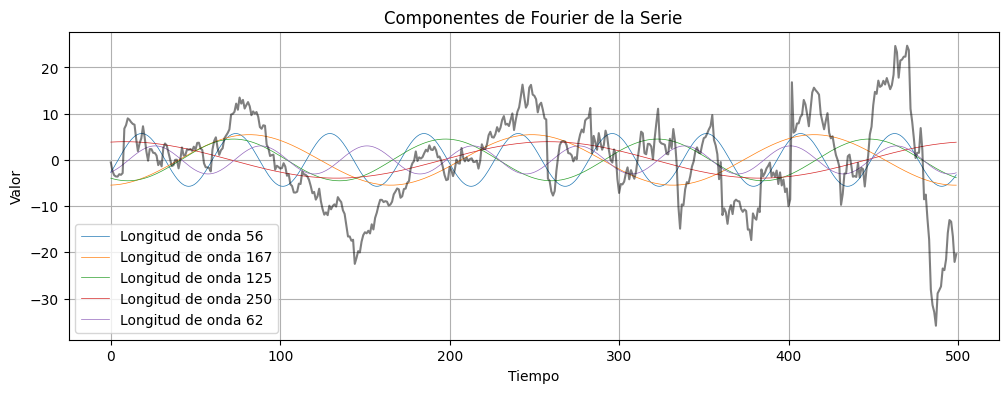

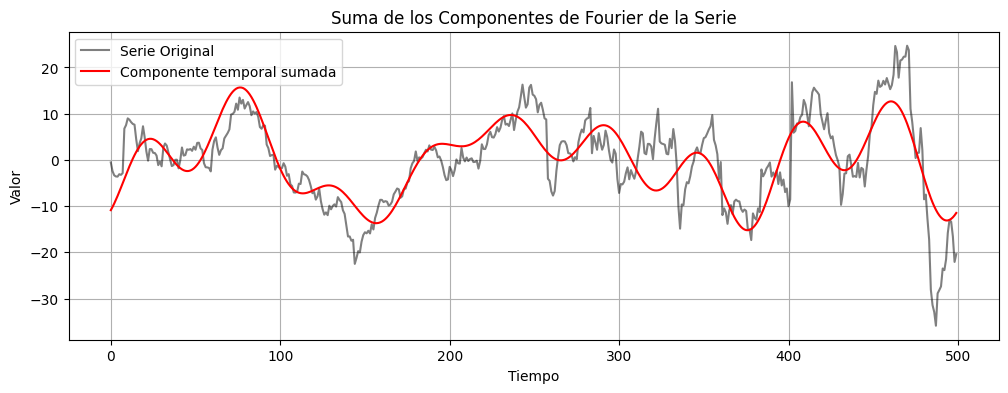

In [8]:
serie = df['Poly_Resid'].values
terminos = 5
un_grafico = False

cts = Transformada_de_Fourier(serie, terminos, un_grafico)

# cts: componente temporal sumado

Gráfico de autocorrelación

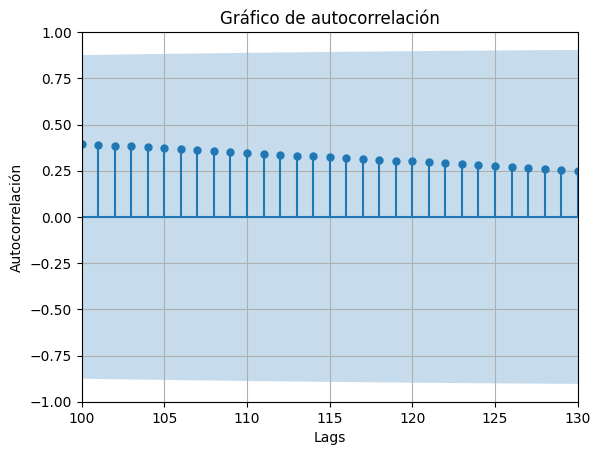

In [9]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

nivel_de_significancia = 0.05

plot_acf(
    df['JPM_Close'],
    lags=130,
    alpha=nivel_de_significancia
    )

plt.xlim([100, 130])
plt.ylim([-1, 1])
plt.title('Gráfico de autocorrelación')
plt.xlabel('Lags')
plt.ylabel('Autocorrelación')
plt.grid()
plt.show()

Gráfico de autocorrelación parcial (PACF)

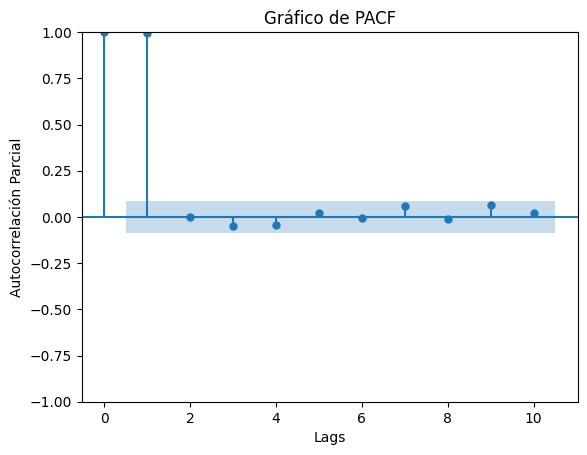

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf

nivel_de_significancia = 0.05
plot_pacf(df['JPM_Close'], lags=10, alpha=nivel_de_significancia)
plt.title('Gráfico de PACF')
plt.xlabel('Lags')
plt.ylabel('Autocorrelación Parcial')
plt.show()

Descomposición de la serie

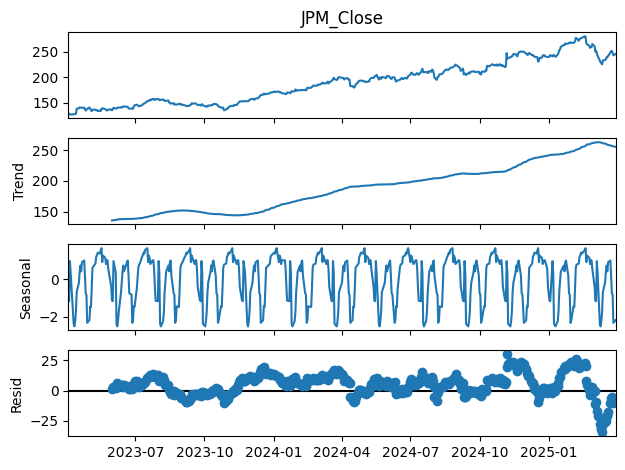

In [11]:
import statsmodels.api as sm

descomposicion = sm.tsa.seasonal_decompose(
    df['JPM_Close'],
    model='additive',
    period=40,
    extrapolate_trend=0,
    two_sided=False,
    )  # 252 días de negociación al año
fig = descomposicion.plot()
plt.show()

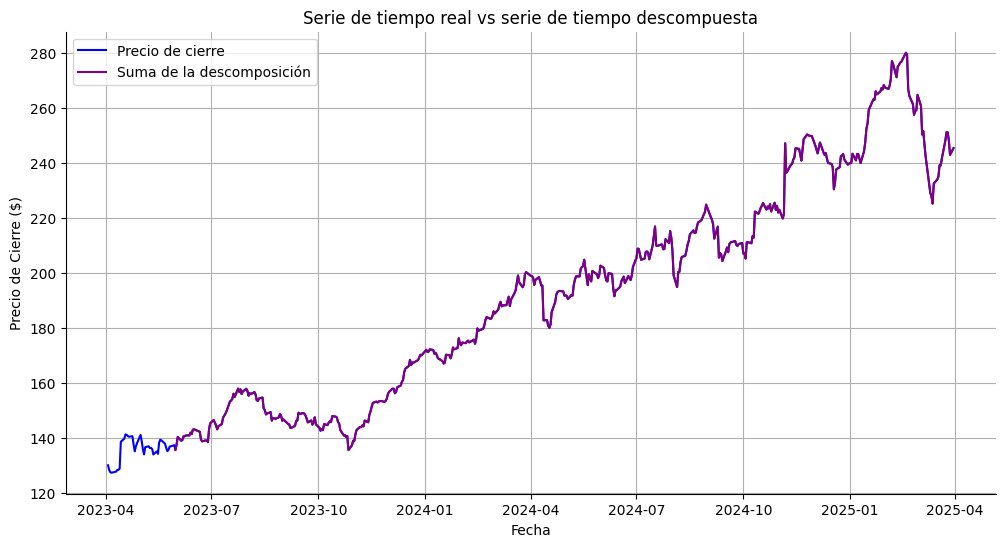

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(df['JPM_Close'], label='Precio de cierre', color='blue')
plt.plot(descomposicion.trend + descomposicion.seasonal + descomposicion.resid, label=f'Suma de la descomposición', color='purple')
plt.title('Serie de tiempo real vs serie de tiempo descompuesta')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

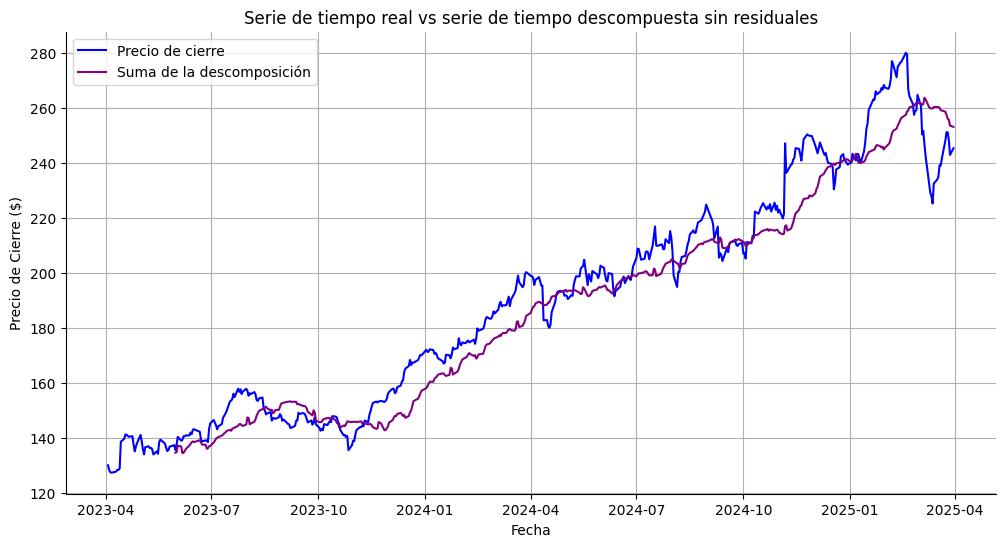

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(df['JPM_Close'], label='Precio de cierre', color='blue')
plt.plot(descomposicion.trend + descomposicion.seasonal, label=f'Suma de la descomposición', color='purple')
plt.title('Serie de tiempo real vs serie de tiempo descompuesta sin residuales')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

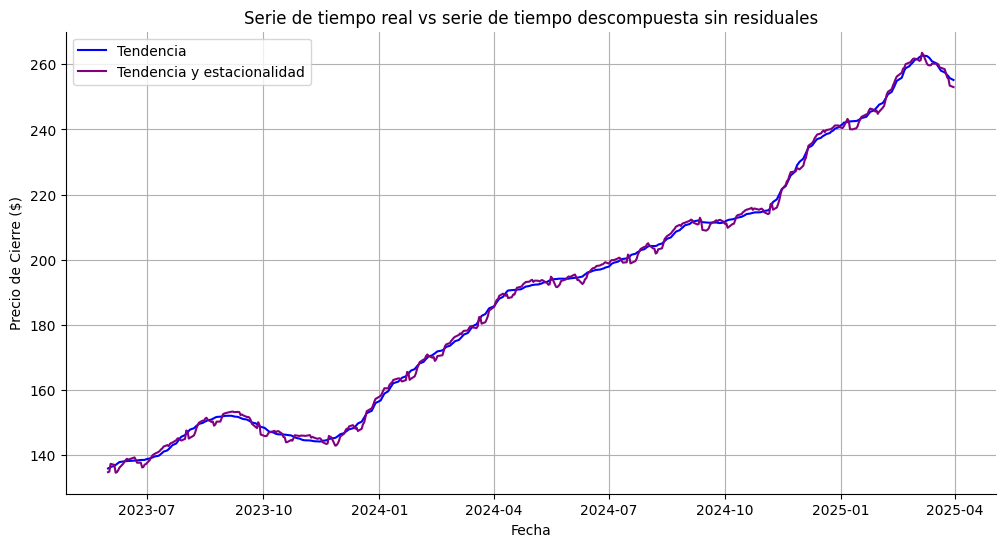

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(descomposicion.trend, label='Tendencia', color='blue')
plt.plot(descomposicion.trend + descomposicion.seasonal, label=f'Tendencia y estacionalidad', color='purple')
plt.title('Serie de tiempo real vs serie de tiempo descompuesta sin residuales')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

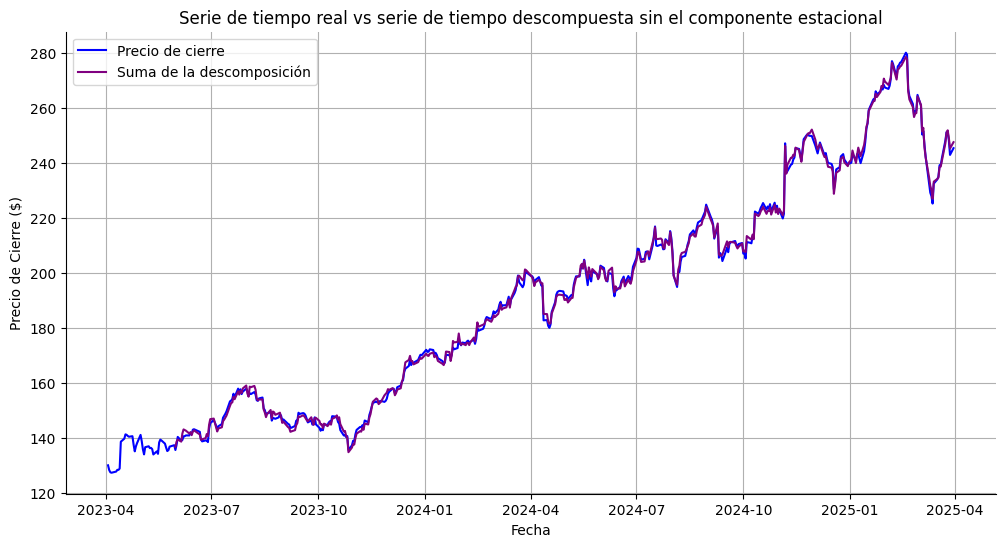

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(df['JPM_Close'], label='Precio de cierre', color='blue')
plt.plot(descomposicion.trend + descomposicion.resid, label=f'Suma de la descomposición', color='purple')
plt.title('Serie de tiempo real vs serie de tiempo descompuesta sin el componente estacional')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

Prueba t pareada para verificar si la estacionalidad tiene un efecto significativo

In [16]:
from scipy.stats import ttest_rel

#Hipótesis nula (H₀): Ambas series son iguales.
#Hipótesis alternativa (H₁): Ambas series son diferentes

nivel_de_significancia = 0.05
tendencia = descomposicion.trend
tendencia_estacionalidad = descomposicion.seasonal + descomposicion.trend

tendencia.dropna(inplace=True)
tendencia_estacionalidad.dropna(inplace=True)

t_stat, p_valor = ttest_rel(tendencia, tendencia_estacionalidad)

print("Estadístico t:", t_stat)
print("Valor p:", p_valor)
print("\n")

if p_valor < nivel_de_significancia:
    print("El valor p es menor que 0.05, por lo tanto, rechazamos la hipótesis nula.")
    print("Conclusión: La estacionalidad tiene un efecto significativo en la serie de tiempo.")
else:
    print("El valor p es mayor o igual que 0.05, por lo tanto, no podemos rechazar la hipótesis nula.")
    print("Conclusión: La estacionalidad no tiene un efecto significativo en la serie de tiempo.")

Estadístico t: 0.49181814183559036
Valor p: 0.6230830268107279


El valor p es mayor o igual que 0.05, por lo tanto, no podemos rechazar la hipótesis nula.
Conclusión: La estacionalidad no tiene un efecto significativo en la serie de tiempo.


Prueba Wilcoxon pareada para verificar si la estacionalidad tiene un efecto significativo

In [17]:
from scipy.stats import wilcoxon

#Hipótesis nula (H₀): Ambas series son iguales.
#Hipótesis alternativa (H₁): Ambas series son diferentes

tendencia = descomposicion.trend
tendencia_estacionalidad = descomposicion.seasonal + descomposicion.trend

tendencia.dropna(inplace=True)
tendencia_estacionalidad.dropna(inplace=True)

w_stat, p_valor = wilcoxon(tendencia, tendencia_estacionalidad)

print("Estadístico de Wilcoxon:", w_stat)
print("Valor p:", p_valor)
print("\n")

if p_valor < 0.05:
    print("El valor p es menor que 0.05, por lo tanto, rechazamos la hipótesis nula.")
    print("Conclusión: La estacionalidad tiene un efecto significativo en la serie de tiempo.")
else:
    print("El valor p es mayor o igual que 0.05, por lo tanto, no podemos rechazar la hipótesis nula.")
    print("Conclusión: La estacionalidad no tiene un efecto significativo en la serie de tiempo.")

Estadístico de Wilcoxon: 51658.0
Valor p: 0.634270374641503


El valor p es mayor o igual que 0.05, por lo tanto, no podemos rechazar la hipótesis nula.
Conclusión: La estacionalidad no tiene un efecto significativo en la serie de tiempo.
